# Linear Regression with mini-batch

* Regression includes many techniques for modeling and analyzing several variables, when the focus is on the relationship between a dependent variable and one or more independent variables (or 'predictors'). [Ref.: Wikipedia, "Regression analysis" page](https://en.wikipedia.org/wiki/Regression_analysis)

$$y_{\textrm{pred}} = \boldsymbol{w}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = w_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$$
where $w_{0} = b$.

* $\mathbf{x} = [x_{1}, x_{2}, \cdots, x_{d}]^{\top}$
* $\mathbf{w} = [w_{1}, w_{2}, \cdots, w_{d}]^{\top}$
* Loss function: $\mathcal{L} = \sum^{N} (y_{\textrm{pred}} - y)^{2}$
  * where $N$ is a number of examples

## Import

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

## Data generation

We make a simple dataset based on model which follows equation

$$y = a x + b + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma_{x})$$

where $a = 4$, $b = -3$, the error term $\varepsilon$ is sampled on normal distributon which variance $\sigma$ depends on the value of $x$ for educational purpose.

In [2]:
np.random.seed(219)
N = 200
a = 4
b = -3
low = -3.0
high = 4.0
data_x = np.random.uniform(low=low, high=high, size=N)
data_y = np.zeros(N)
for i, x in enumerate(data_x):
  scale = - (x - low) * (x - high) / 3. + 1.5
  data_y[i] = a * x + b + np.random.normal(loc=0.0, scale=scale, size=1)

### Data plot

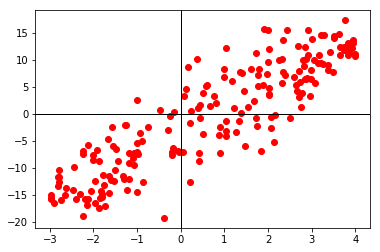

In [3]:
plt.plot(data_x, data_y, 'ro')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.show()

## Exact solution of linear regression

Linear regression model is
$$y_{\textrm{pred}} = \boldsymbol{w}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = w_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$$
where $w_{0} = b$.

Extend the class of models by considering linear combinations of fixed nonlinear functions of the input variables

$$y_{\textrm{pred}} = w_{0} + w_{1} \phi_{1}(\mathbf{x}) + w_{2} \phi_{2}(\mathbf{x}) + \cdots + w_{M-1} \phi_{M-1}(\mathbf{x}),$$

$$y_{\textrm{pred}} = w_{0} + \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}).$$

$\phi_{j}(\mathbf{x})$ is called *basis function*.
And add dummy 'basis function' $\phi_{0}(\mathbf{x}) = 1$ so that

$$y_{\textrm{pred}} = \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}) = \mathbf{w}^{\top} \boldsymbol{\phi}(\mathbf{x}).$$

### Normal Equation (analytic solution of linear model)

$$\mathbf{w} = (\mathbf{\Phi}^{\top} \mathbf{\Phi})^{-1} (\mathbf{\Phi}^{\top} \mathbf{Y})$$

where $\mathbf{\Phi}$ is a $N \times M$ matrix, called *design matrix*

$$\mathbf{\Phi} = \left( \begin{array}{llll}
\phi_{0}(\mathbf{x_{1}}) & \phi_{1}(\mathbf{x_{1}}) & \cdots & \phi_{M-1}(\mathbf{x_{1}})\\
\phi_{0}(\mathbf{x_{2}}) & \phi_{1}(\mathbf{x_{2}}) & \cdots & \phi_{M-1}(\mathbf{x_{2}})\\
\vdots & \vdots & \ldots & \vdots\\
\phi_{0}(\mathbf{x_{N}}) & \phi_{1}(\mathbf{x_{N}}) & \cdots & \phi_{M-1}(\mathbf{x_{N}})
\end{array} \right).$$

And $\mathbf{Y}$ is a target vector (label data)
* $\mathbf{Y} = [y_{1}, y_{2}, \cdots, y_{N}]^{\top}$

### Problem

* This is a our problem.
$$y_{\textrm{pred}} = w_{0} + w_{1} x,$$

$$y_{\textrm{pred}} = \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}) = \mathbf{w}^{\top} \boldsymbol{\phi}(\mathbf{x}).$$

* Write $\mathbf{\Phi}$ on your paper
  1. First, write $\phi_{0}(\mathbf{x})$ and $\phi_{1}(\mathbf{x})$.
  2. Second, consider how the design matrix $\mathbf{\Phi}$ looks like

### Implement $\Phi$, $\mathbf{Y}$

* X: $\Phi$
* Y: $\mathbf{Y}$

In [4]:
# using data_x, data_y
X = np.concatenate((data_x.reshape(N, 1), np.ones(N).reshape(N, 1)), axis=1)
Y = data_y.reshape(N, 1)

### Implement $\mathbf{w} = (\mathbf{\Phi}^{\top} \mathbf{\Phi})^{-1} (\mathbf{\Phi}^{\top} \mathbf{Y})$

* A: $\mathbf{\Phi}^{\top} \mathbf{\Phi}$
* invA: inverse of A
* B: $\mathbf{\Phi}^{\top} \mathbf{Y}$
* W_exact: $\mathbf{w}$ with shape: (2,)
* matrix inversion: `np.linalg.inv(A)`

In [5]:
%time
A = np.matmul(X.T, X)
invA = np.linalg.inv(A)
B = np.matmul(X.T, Y)
W_exact = np.matmul(invA, B)
W_exact = np.squeeze(W_exact)
minima = W_exact.reshape(2, 1)

CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 11 µs


In [6]:
minima = W_exact.reshape(2, 1) # for 3D plot and contour plot

In [7]:
print("Real parameters used creating the data")
print("w: {:.4f}  b: {:.4f}".format(a, b))
print("Exact Solution using the normal equation")
print("w: {:.4f}  b: {:.4f}".format(W_exact[0], W_exact[1]))

Real parameters used creating the data
w: 4.0000  b: -3.0000
Exact Solution using the normal equation
w: 4.1533  b: -3.2426


## Training Pseudo Code using Gradient Descent

```python
for epoch in max_epochs: # 1 epoch: 모든 데이터(N)를 한번 학습 시켰을 때
  for step in num_batches: # num_batches = int(data_size / batch_size)
    1. sampling mini-batches with batch_size
      1-1. data augmentation (when you need)
    2. calculate the logits # logits = f(x)
    3. calculate the loss # loss = loss(logits, labels)
    4. calculate the gradient with respect to weights
    5. update weights
```

## Build a LinearRegression model

In [8]:
class LinearRegression(object):
  def __init__(self, data_x, data_y, w_init=None, b_init=None,
               learning_rate=0.1, batch_size=1):
    scale = 4.0
    if w_init is not None:
      self.w = w_init
    else:
      self.w = np.random.uniform(low=a-scale, high=a+scale)
    if b_init is not None:
      self.b = b_init
    else:
      self.b = np.random.uniform(low=b-scale, high=b+scale)
    print("w_init: {:.3f}".format(self.w))
    print("b_init: {:.3f}".format(self.b))
      
    self.x = data_x
    self.y = data_y
    self.lr = learning_rate
    self.batch_size = batch_size
    
    # for accumulation of loss and path (w, b)
    self.loss_history = []
    self.w_history = []
    self.b_history = []
  
  def inference(self, x):
    """Inference function for a linear model
      y_pred = w * x + b.
    
    Args:
      x: mini-batch data, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      y_pred: mini-batch y_pred, shape: (1-rank Tensor (vector) np.array)
    """
    y_pred = self.w * x + self.b
    return y_pred
  
  def loss_for_plot(self, w, b):
    """List of loss function with respect to given list of (w, b).
      
    Args:
      w: shape: (1-rank Tensor (vector) np.array)
      b: shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss_for_plot: shape: (1-rank Tensor (vector) np.array)
    """
    y_pred = np.matmul(np.expand_dims(self.x, axis=1), np.expand_dims(w, axis=0)) + b
    loss_for_plot = 0.5 * (y_pred - np.expand_dims(self.y, axis=1))**2
    loss_for_plot = np.mean(loss_for_plot, axis=0)
    return loss_for_plot
  
  def loss_fn(self, labels, predictions):
    """Loss function.
    
    Args:
      labels: target data y, shape: (1-rank Tensor (vector) np.array)
      predictions: model inference y_pred, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss: mean value of loss for full-batch data, shape: (0-rank Tensor (scalar))
    """
    loss = 0.5 * np.mean((predictions - labels)**2)
    return loss
  
  def loss_derivative(self, inputs, labels, predictions):
    """Loss derivative.
    
    Args:
      inputs: input data x, shape: (m,) m: batch_size (1-rank Tensor (vector) np.array)
      labels: target data y, shape: (m,) m: batch_size (1-rank Tensor (vector) np.array)
      predictions: model inference y_pred, (m,) m: batch_size shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      dw: dL / dw, mean value of derivatives for mini-batch data, shape: (0-rank Tensor (scalar))
      db: dL / db, mean value of derivatives for mini-batch data, shape: (0-rank Tensor (scalar))
    """
    dw = np.mean((predictions - labels) * inputs)
    db = np.mean(predictions - labels)
    return dw, db
  
  def weights_update(self, dw, db):
    """Weights update using Gradient descent.
    
      w' = w - lr * dL/dw
    """
    self.w = self.w - self.lr * dw
    self.b = self.b - self.lr * db
    
  def history_update(self, loss, w, b):
    """Accumulate all interesting variables
    """
    self.loss_history.append(self.loss)
    self.w_history.append(self.w)
    self.b_history.append(self.b)
    
  def train(self, max_epochs):
    pre_loss = 0.0
    total_steps = 1
    num_batches_per_epoch = int(len(self.x) / self.batch_size)
    print("total_steps: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}".format(0, self.loss_fn(self.x, self.y), self.w, self.b))
    for epoch in range(max_epochs):
      shuffle_index = np.random.permutation(N)
      #shuffle_index = np.range(N) # non-shuffling case
      
      for step in range(num_batches_per_epoch):
        batch_x = self.x[shuffle_index[step*self.batch_size:(step+1)*self.batch_size]]
        batch_y = self.y[shuffle_index[step*self.batch_size:(step+1)*self.batch_size]]
        
        self.y_pred = self.inference(batch_x)
        self.loss = self.loss_fn(batch_y, self.y_pred)
        self.history_update(self.loss, self.w, self.b)
      
        #inputs, labels, predictions
        self.dw, self.db = self.loss_derivative(batch_x, batch_y, self.y_pred)
        self.weights_update(self.dw, self.db)
        print("epochs: {}  total_steps: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}  dw: {:.5f}  db: {:.5f}".format(epoch, total_steps, self.loss, self.w, self.b, self.dw, self.db))
      
        pre_loss = self.loss
        total_steps += 1
        
    print("End of training")
    print("total_steps: {}  loss: {:.6f}  w: {:.4f}  b: {:.4f}".format(total_steps-1, self.loss, self.w, self.b))
    
    self.w_history = np.array(self.w_history)
    self.b_history = np.array(self.b_history)
    self.path = np.concatenate((np.expand_dims(self.w_history, 1), np.expand_dims(self.b_history, 1)), axis=1).T

### Create a `LinearRegression` class

In [9]:
model = LinearRegression(data_x, data_y, w_init=1., b_init=0., learning_rate=0.01, batch_size=20)
#model = LinearRegression(data_x, data_y, w_init=None, b_init=None, learning_rate=0.1, batch_size=20)

w_init: 1.000
b_init: 0.000


### Training

In [10]:
%time
model.train(50)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.9 µs
total_steps: 0  loss: 32.958153  w: 1.00000  b: 0.00000
epochs: 0  total_steps: 1  loss: 27.219236  w: 1.13895  b: 0.00981  dw: -13.89498  db: -0.98115
epochs: 0  total_steps: 2  loss: 41.692493  w: 1.32610  b: -0.00743  dw: -18.71513  db: 1.72395
epochs: 0  total_steps: 3  loss: 33.596282  w: 1.41909  b: -0.04143  dw: -9.29862  db: 3.40015
epochs: 0  total_steps: 4  loss: 31.076860  w: 1.55920  b: -0.06515  dw: -14.01145  db: 2.37221
epochs: 0  total_steps: 5  loss: 33.369502  w: 1.70294  b: -0.08356  dw: -14.37409  db: 1.84119
epochs: 0  total_steps: 6  loss: 25.498307  w: 1.78009  b: -0.07518  dw: -7.71446  db: -0.83878
epochs: 0  total_steps: 7  loss: 14.897459  w: 1.82693  b: -0.10167  dw: -4.68391  db: 2.64963
epochs: 0  total_steps: 8  loss: 25.497710  w: 1.91137  b: -0.11815  dw: -8.44479  db: 1.64737
epochs: 0  total_steps: 9  loss: 17.259908  w: 1.97753  b: -0.14149  dw: -6.61511  db: 2.33441
epochs: 0  total_ste

### Results

In [11]:
print("Real parameters used creating the data")
print("w: {:.4f}  b: {:.4f}".format(a, b))
print("Exact Solution using the normal equation")
print("w: {:.4f}  b: {:.4f}".format(W_exact[0], W_exact[1]))
print("Solution using the gradient descent")
print("w: {:.4f}  b: {:.4f}".format(model.w, model.b))

Real parameters used creating the data
w: 4.0000  b: -3.0000
Exact Solution using the normal equation
w: 4.1533  b: -3.2426
Solution using the gradient descent
w: 4.1433  b: -3.2011


### Loss function plot

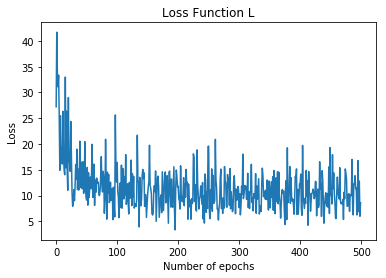

In [12]:
#Plot the loss function
plt.title('Loss Function L')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.plot(model.loss_history)
plt.show()

### Plot the data with our model

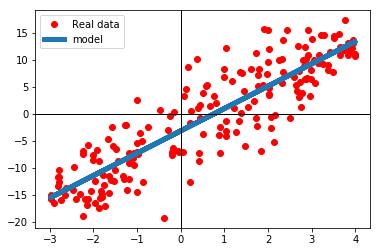

In [13]:
plt.plot(data_x, data_y, 'ro', label='Real data')
plt.plot(data_x, model.w * data_x + model.b, lw=5, label='model')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()
plt.show()

## Plot loss surface function

In [14]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.
w_min = a - margin
w_max = a + margin
b_min = b - margin
b_max = b + margin
w_points = np.linspace(w_min, w_max, number_of_points) 
b_points = np.linspace(b_min, b_max, number_of_points)
w_mesh, b_mesh = np.meshgrid(w_points, b_points)
loss_ = np.array([model.loss_for_plot(wps, bps) for wps, bps in zip(w_mesh, b_mesh)])

### 3D plot with learning path

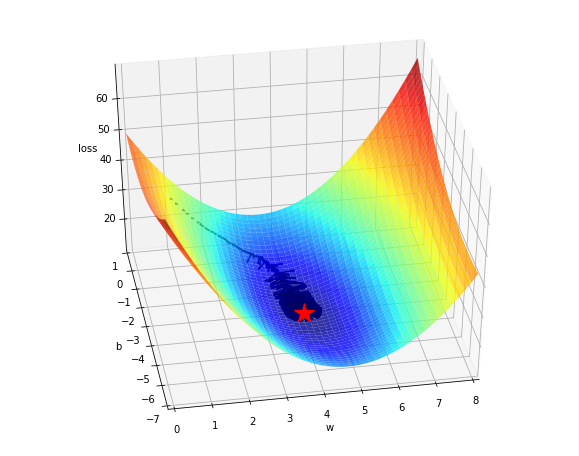

In [15]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

path = model.path

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=40, azim=-100)

ax.plot_surface(w_mesh, b_mesh, loss_, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)

ax.plot(*minima, model.loss_for_plot(*minima), 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], model.loss_for_plot(*path[::,:-1]),
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          model.loss_for_plot(*path[::,1:]) - model.loss_for_plot(*path[::,:-1]),
          color='k', length=0.5, normalize=True)

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')

ax.set_xlim((w_min, w_max))
ax.set_ylim((b_min, b_max))

#plt.draw()
plt.show()

### Contour plot with learning path

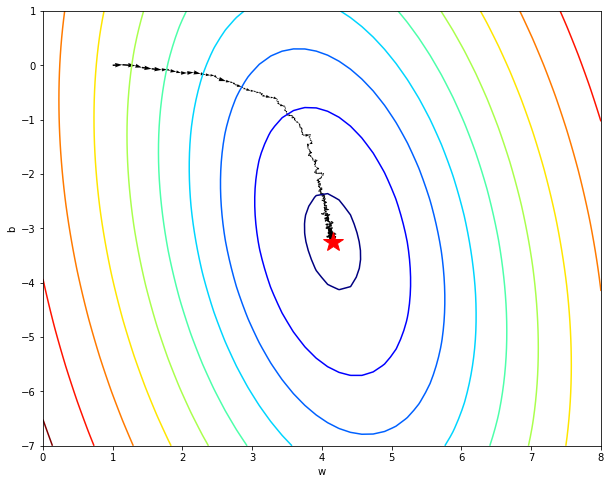

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(w_mesh, b_mesh, loss_, levels=np.logspace(-1, 2, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          scale_units='xy', angles='xy', scale=1, color='k')

ax.set_xlabel('w')
ax.set_ylabel('b')

ax.set_xlim((w_min, w_max))
ax.set_ylim((b_min, b_max))

plt.show()